In [17]:
# For visualization and data wrangling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Utilities for imports and typehinting
from pathlib import Path
from typing import Dict, Optional, Tuple
import os

### Data imports

Each file is gene-level MAGeCK-RRA output for and independent screen (BCBL1 sgRNA/shRNA depletion rescue or BC2 sgRNA depletion rescue)

See MAGeCK's documentation for full description of columns.

In [18]:
FILE_DIR = os.path.abspath('')
FILE_DIR = Path(FILE_DIR)
DATA_DIR = FILE_DIR / 'Data'
PLOT_DIR = FILE_DIR / 'Plots'

In [19]:
## Input the name of some dataset with columns/rows matching the data to plot
files = {
    'shCFLIP_v_Ren_BCBL1': 'BCBL1_shCFLIP_v_Ren.gene_summary.txt',
    'sgCFLIP_v_AAVS1_BCBL1': 'BCBL1_sgCFLIP_v_AAVS1.gene_summary.txt',
    'sgCFLIP_v_AAVS1_BC2': 'BC2_sgCFLIP_v_AAVS1.gene_summary.txt',
    }

for f in files:
    files[f] = DATA_DIR / files[f]

## Indicate delimiter as a string
delim_type = '\t'

In [20]:
data = {}

for dataset, file in files.items():
    df = pd.read_csv(
        file,
        sep = delim_type,
        header = 0,
        index_col = 0
        )

    df = df.add_prefix(dataset+'_')
    neg_log_p = -np.log2(df[f'{dataset}_pos|p-value'])
    df[f'{dataset}_pos|Neglog2_p-value'] = neg_log_p
    
    data[dataset] = df

# Genesets

Here I'm just defining some dictionary objects to store genesets and assigning them colors to use for imaging.

In [21]:
extrinsic = {
    'TNFRSF10A': 'lightcoral',
    'FADD': 'firebrick',
    'CASP8': 'crimson'
    }

ufmylation = {
    'UBA5': 'lightsteelblue',
    'UFSP2': 'royalblue',
    'UFM1': 'dodgerblue',
    'UFC1': 'blue',
    'DDRGK1': 'navy',
    'UFL1': 'deepskyblue',
    'C1orf27': 'cornflowerblue'
    }

chondroitin = {
    'UXS1': 'greenyellow',
    'XYLT2': 'lightgreen',
    'CSGALNACT1': 'forestgreen',
    'B4GALT7': 'darkgreen',
    'B3GAT3': 'lime',
    'PAPSS1': 'seagreen',
    'SLC35B2': 'springgreen',
    'CHST15': 'aquamarine',
    'UGDH': 'lightseagreen'
    }

srp = {
    'SRP68': 'indigo',
    'SRP72': 'darkorchid',
    'SRP54': 'violet',
    'SRP14': 'mediumvioletred',
    'SRP9': 'purple'
    }

other = {
    'EHMT2': 'goldenrod',
    'CXCR4': 'darkorange',
    'JAGN1': 'tan',
    }

near_misses = {
    'SLC39A1': 'orange',
    'TMEM208': 'yellow',
    'UFL1': 'green',
    'GANAB': 'blue',
    'PPCS': 'indigo',
    'RSL24D1': 'violet',
    'BIRC6': 'black'
}

high_conf = {**extrinsic, **ufmylation, **chondroitin, **{k:v for k,v in srp.items() if k in ['SRP68', 'SRP72']}, **other}

genesets = {
    'Extrinsic': extrinsic,
    'UFMylation': ufmylation,
    'Chondroitin': chondroitin,
    'SRP': srp,
    'Other': other,
    'High_Conf_Hits': high_conf,
    'Narrow_Misses': near_misses
    }

### Utility Functions
Below I define a function to create a df with labeled gene sets and generate scatterplots with these points labeled

In [22]:
def label_and_plot_geneset(
    df: pd.DataFrame,
    x_col: str,
    x_lab: str,
    y_col: str,
    y_lab: str,
    data_key: str,
    geneset: Dict[str, str],
    geneset_name: str,
    base_color: str,
    figsize: Tuple[float, float],
    scale_factor: Optional[float] = 1,
    legend: bool = True,
    x_line: Optional[float] = None,
    y_line: Optional[float] = None,
    x_lim: Optional[Tuple[float]] = None,
    y_lim: Optional[Tuple[float]] = None,
    invert_axes: bool = False,
    out_pref: Optional[str] = None,
    out_dir: Path = PLOT_DIR
    ):
    """_summary_

    Parameters
    ----------
    df : pd.DataFrame
        dataframe of MAGeCK output to act on
    x_col : str
        column to plot on x axis
    x_lab : str
        label to use for x axis
    y_col : str
        column to plot on y axis
    y_lab : str
        label to use for y axis
    data_key : str
        label for overall figure (based on the screen cell line/type)
    geneset : Dict[str, str]
        dictionary containing gene and color pairs as defined above
    geneset_name : str
        name of the geneset
    base_color : str
        base color to use for labeling points that do not live within the
        provided geneset
    figsize : Tuple[float, float]
        figure size, passed to pylot.figure()
    scale_factor : Optional[float]
        a scaling factr to apply to font/figsize/scatter point sizes
    legend : bool, optional
        whether to add a legend (to hide for genesets)
    x_line : Optional[float], optional
        where to draw a line along the x axis, by default None
    y_line : Optional[float], optional
        where to draw a line along the y axis, by default None
    x_lim : Optional[Tuple[float]], optional
        range of x values to plot, by default None
    y_lim : Optional[Tuple[float]], optional
        range of y values to plot, by default None
    invert_axes : bool, optional
        invert axes (optionally for rank plots), by default False
    out_pref : Optional[str], optional
        file prefix to use for output, by default None
    out_dir : Path, optional
        directory to output plots, by default PLOT_DIR
    """
    
    if out_pref == None:
        out_pref = data_key

    out_path = out_dir/ f'{out_pref}_{geneset_name}.svg'
    gene_list = geneset.keys()
    colors = geneset.values()
    
    df['Labels'] = df.index.values
    df.loc[np.logical_not(df.index.isin(gene_list)), ['Labels']] = ''
    
    for g in gene_list:
        df.loc[df.index == g, ['Labels']] = g
    
    label_cats = pd.CategoricalDtype(
        categories = gene_list,
        ordered = True
        )
    df['Labels'] = df['Labels'].astype(label_cats)

    sns.set_context("talk", font_scale=1.3*scale_factor)
    plt.figure(figsize=[i*scale_factor for i in figsize])
    sns.scatterplot(
        x = f'{data_key}{x_col}', 
        y = f'{data_key}{y_col}',
        legend = legend,
        **{'color': base_color},
        s = 300*scale_factor,
        data = df)
    sns.scatterplot(
        x = f'{data_key}{x_col}', 
        y = f'{data_key}{y_col}',
        legend = legend,
        hue = 'Labels',
        palette = colors,
        s = 400*scale_factor,
        data = df[df['Labels'].isin(gene_list)]
        )

    if invert_axes:
        ax = plt.gca()
        ax.invert_xaxis()
        ax.invert_yaxis()
        
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)

    if y_line:
        plt.axhline(
            y_line,
            linewidth = .75,
            c = 'black',
            linestyle = ':'
            )
    if x_line:
        plt.axvline(
            x_line,
            linewidth = .75,
            c = 'black',
            linestyle = ':'
            )

    if y_lim:
        plt.ylim(y_lim)
    if x_lim:
        plt.xlim(x_lim)

    if legend:
        legend = plt.legend(borderaxespad=.5)
        legend.set_title(geneset_name)

    plt.title(f"{data_key.replace('_','')} (Enrichment)")
    plt.tight_layout()
    plt.savefig(out_path, transparent=False)

/tmp/ipykernel_22755/736697418.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[i*scale_factor for i in figsize])


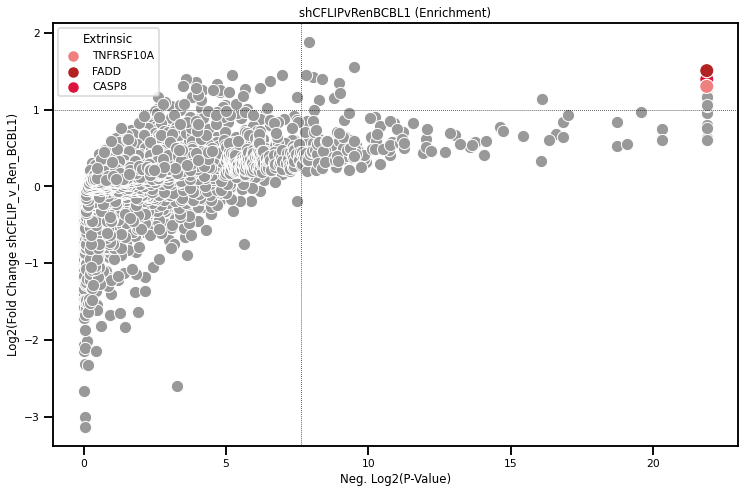

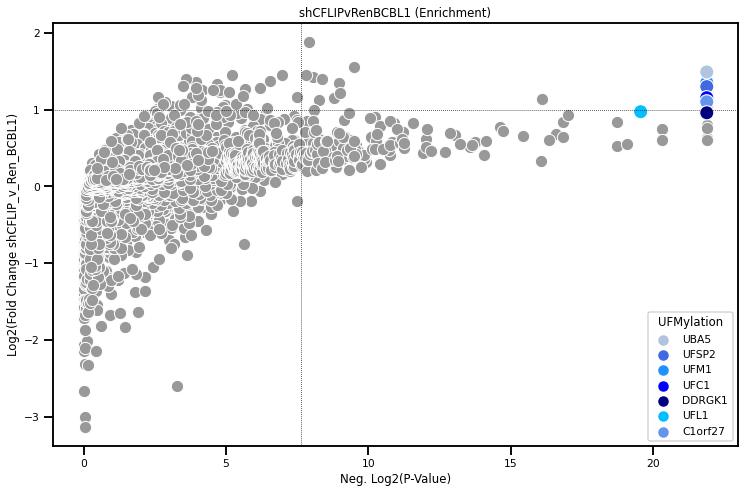

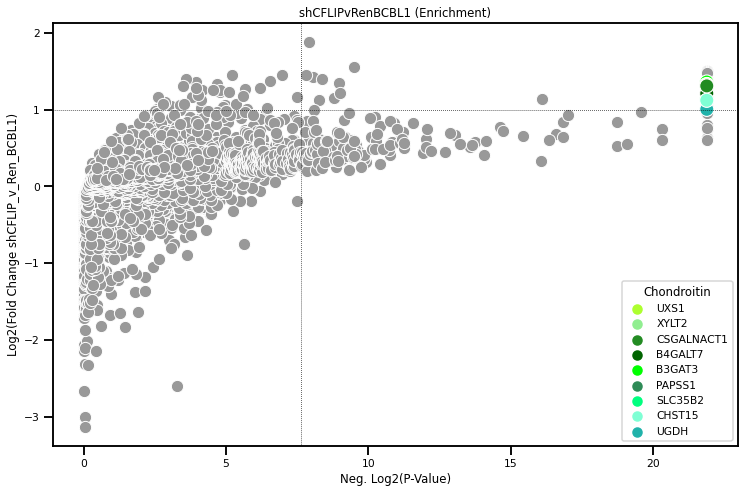

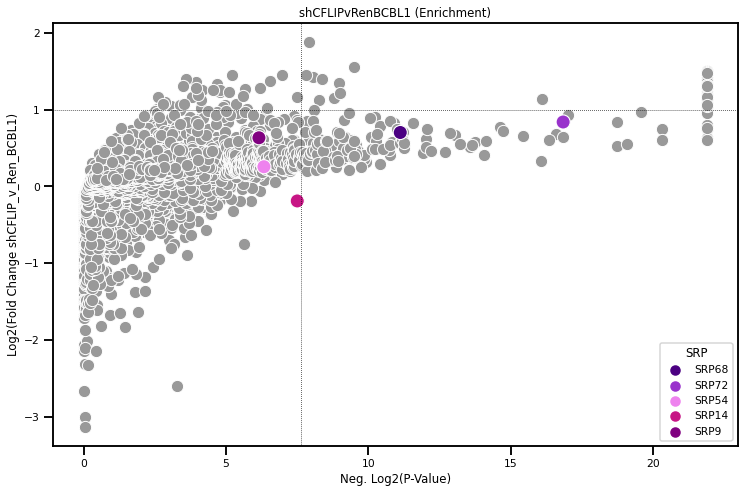

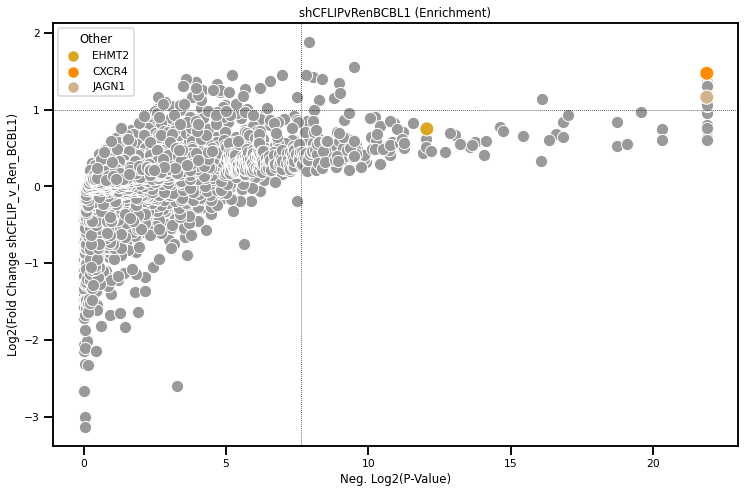

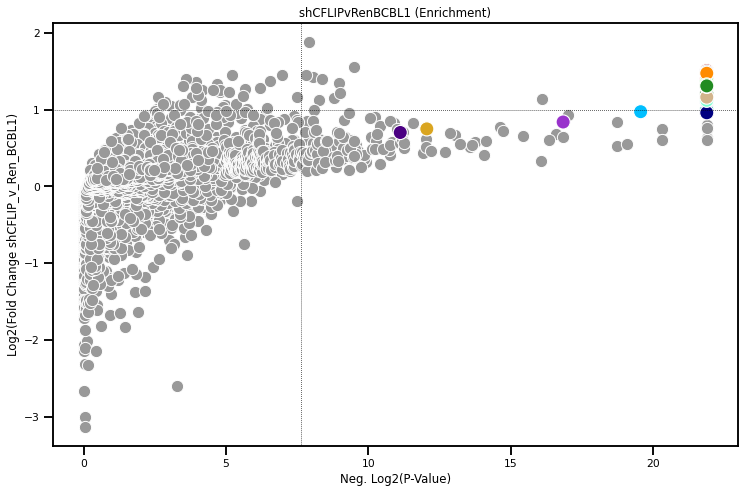

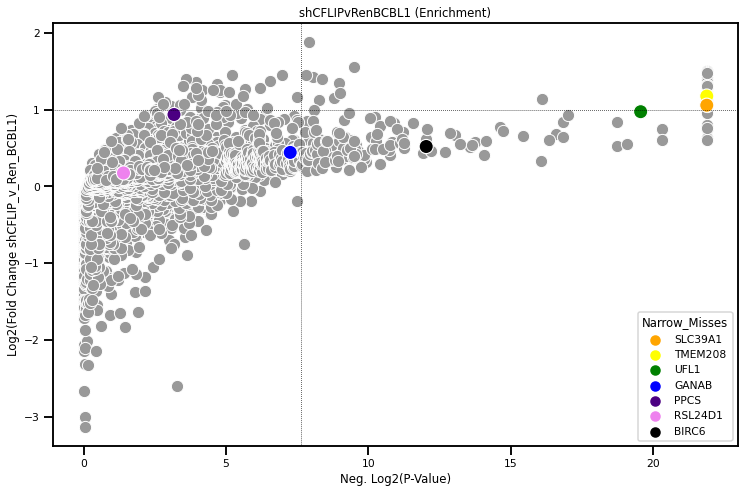

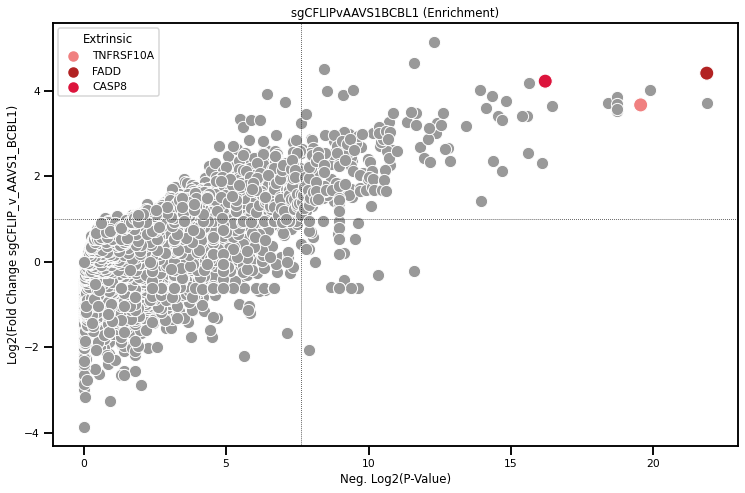

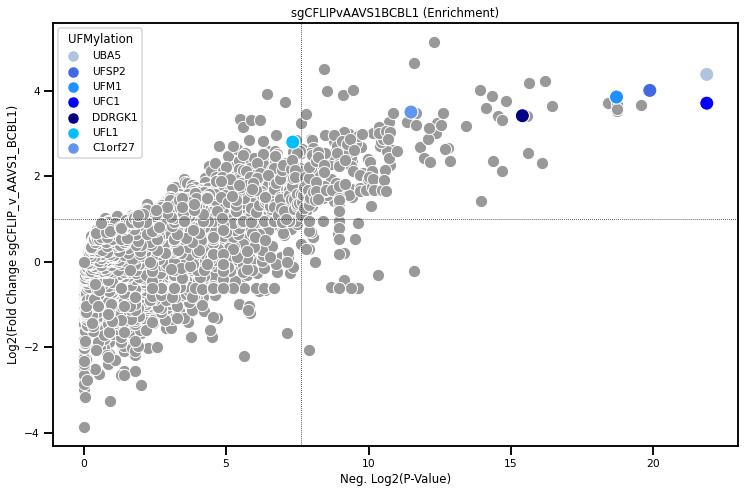

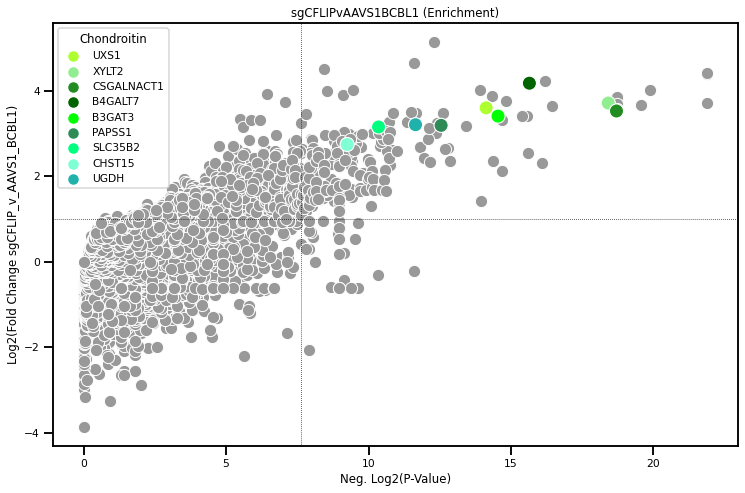

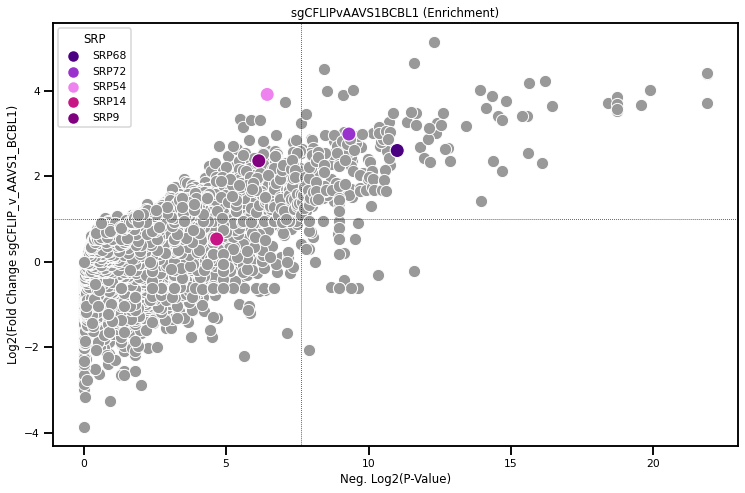

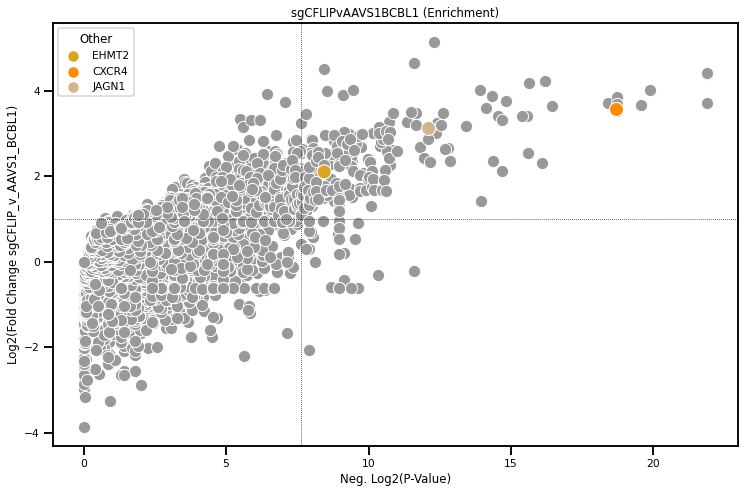

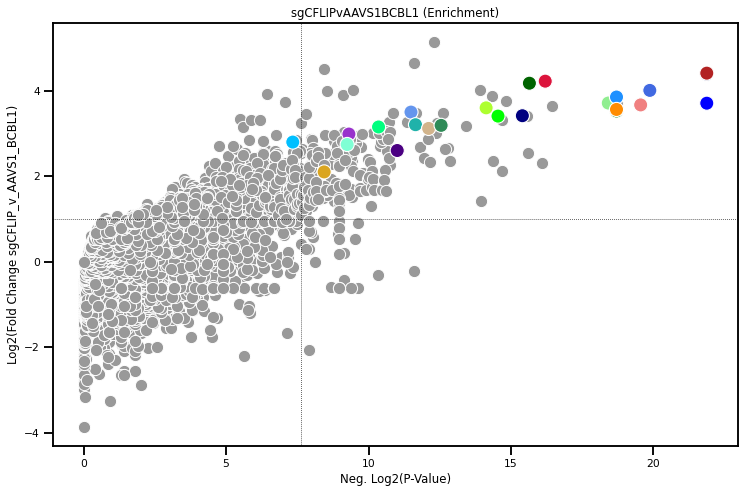

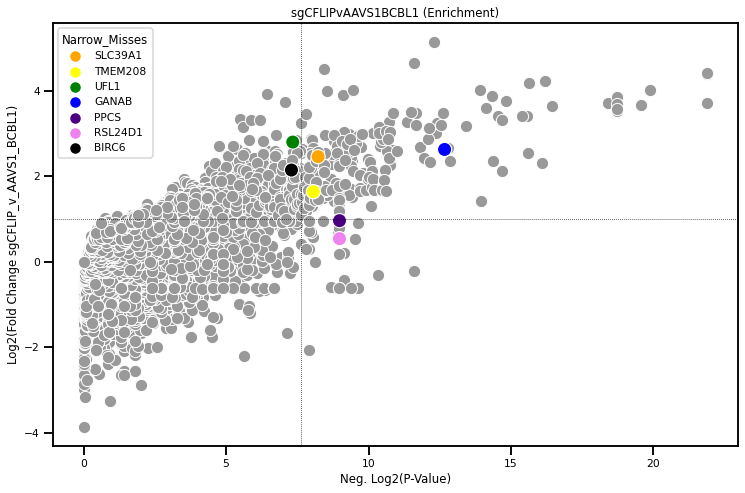

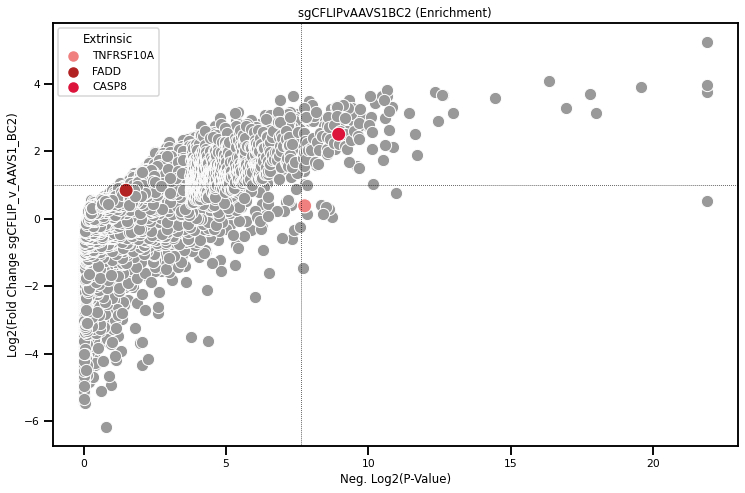

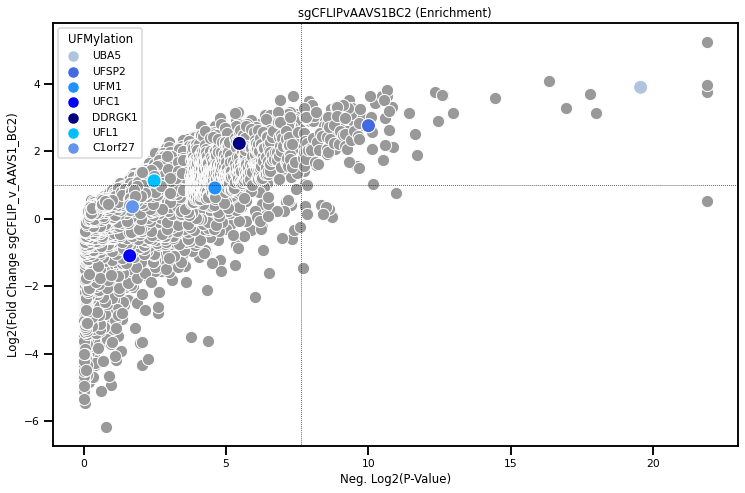

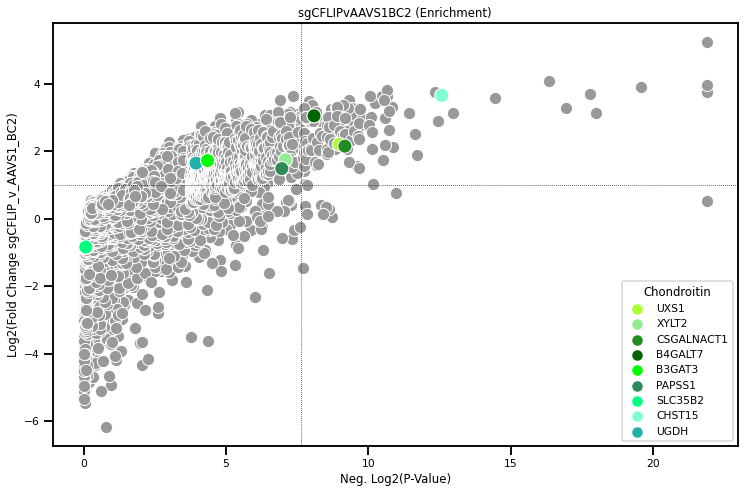

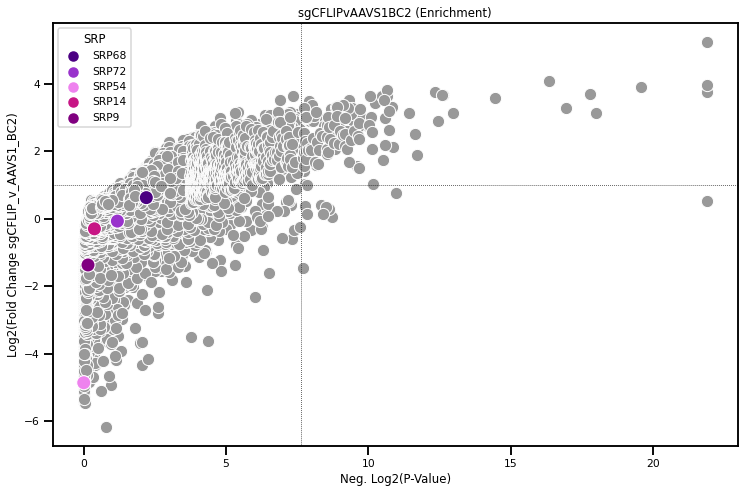

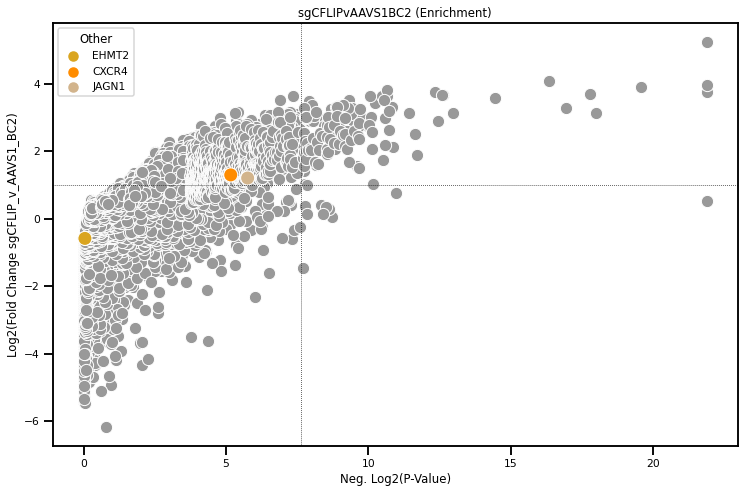

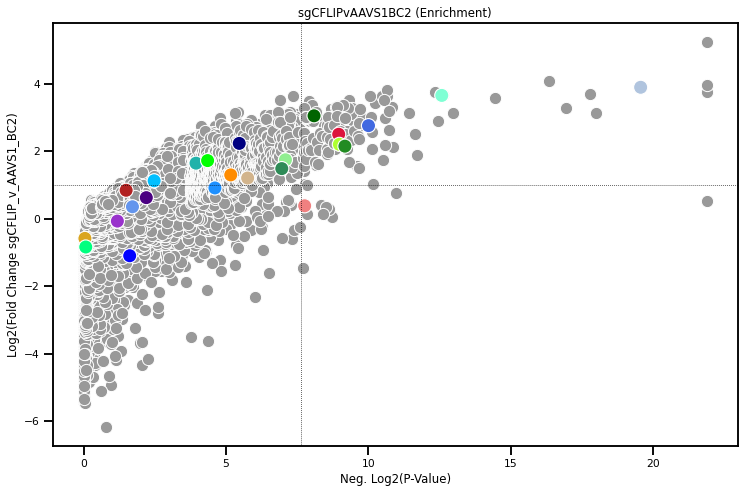

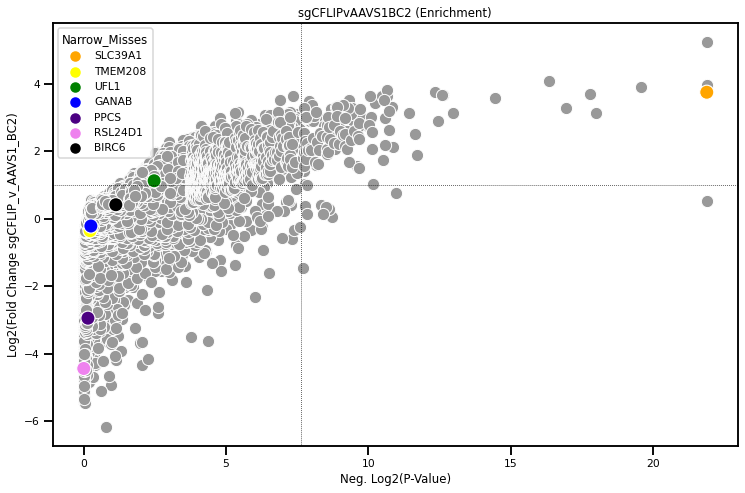

In [23]:
for data_key, df in data.items():
    for geneset_name, geneset in genesets.items():
        draw_legend = geneset_name != 'High_Conf_Hits'
        label_and_plot_geneset(
            df,
            x_col = 'pos|Neglog2_p-value',
            x_lab = 'Neg. Log2(P-Value)',
            y_col = 'pos|lfc',
            y_lab = f'Log2(Fold Change {data_key})',
            data_key = data_key + '_',
            geneset = geneset,
            geneset_name = geneset_name,
            base_color = '.6',
            legend = draw_legend,
            x_line = -np.log2(.005),
            y_line = np.log2(2),
            figsize=(21,14),
            scale_factor=.5
            )

In [24]:
rank_only = lambda df: [c for c in df.columns if 'pos|rank' not in c]
new_data = [df.drop(labels=rank_only(df), axis=1) for df in data.values()]

df = new_data[0]
for i in range(1,len(new_data)):
    df = df.join(new_data[i])
    
df.head(10)

,shCFLIP_v_Ren_BCBL1_pos|rank,sgCFLIP_v_AAVS1_BCBL1_pos|rank,sgCFLIP_v_AAVS1_BC2_pos|rank
id,,,
HSP90B1,19104,5738.0,8907
EXT1,19103,14001.0,3805
SIK3,19102,16009.0,18099
Non-Targeting-Control,2945,19084.0,1
SDC1,18565,18974.0,17361
C9orf41,19101,5446.0,15698
ACTL8,19100,19008.0,17337
ZNF384,19046,15609.0,1051
AIP,16921,16780.0,10867


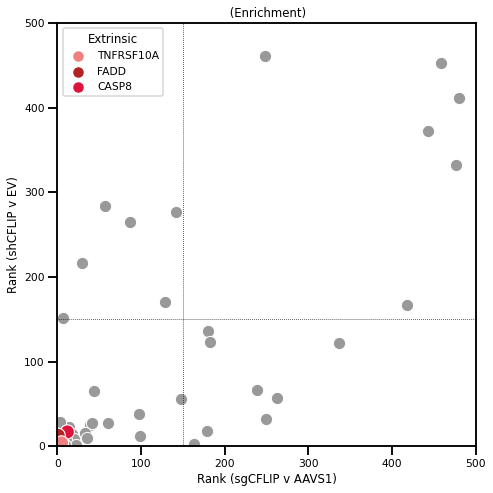

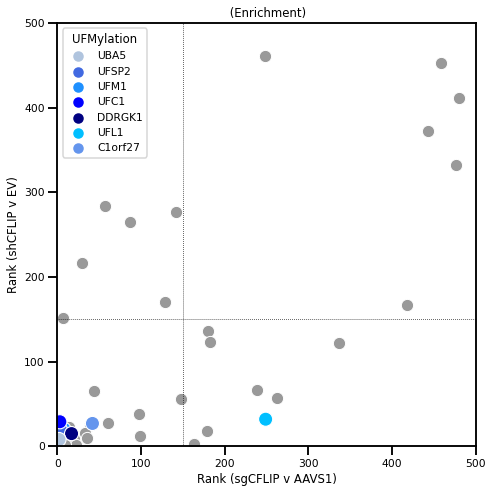

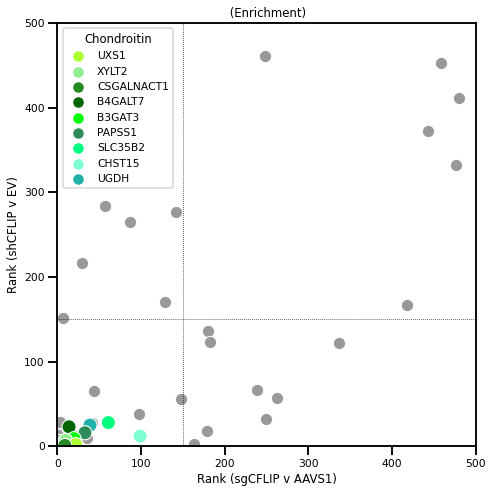

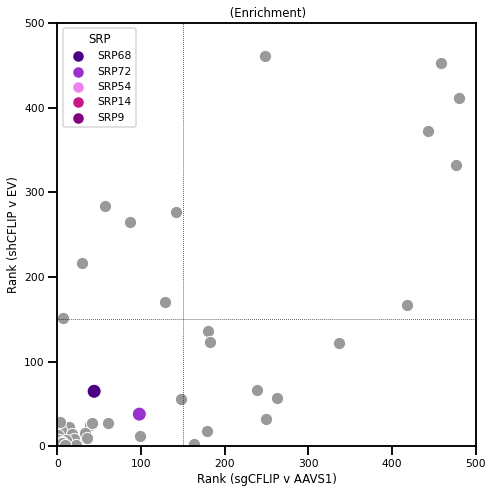

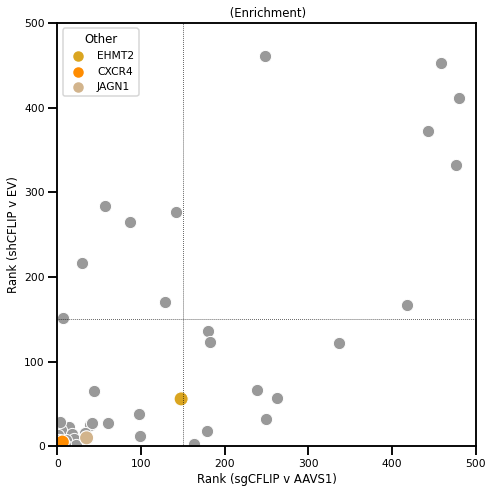

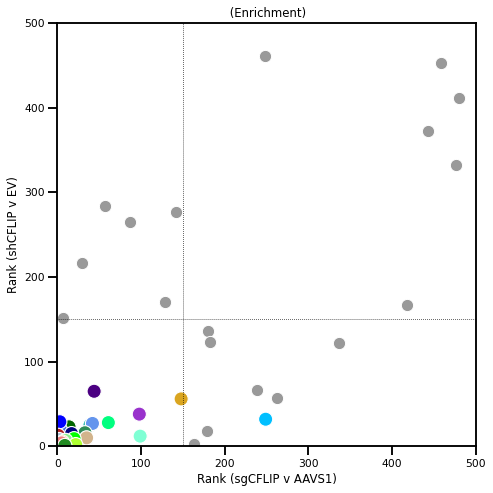

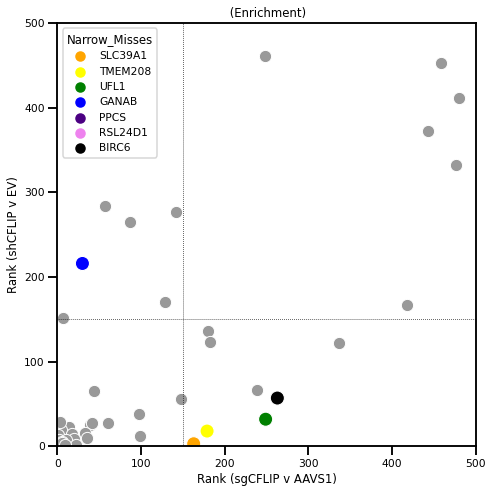

In [25]:
y_col = 'shCFLIP_v_Ren_BCBL1_pos|rank'
x_col = 'sgCFLIP_v_AAVS1_BCBL1_pos|rank'
y_lim = 500
x_lim = 500
ranks_df = df[(df[y_col] <= y_lim) & (df[x_col] <= x_lim)].copy()
for geneset_name, geneset in genesets.items():
    draw_legend = geneset_name != 'High_Conf_Hits'
    label_and_plot_geneset(
        ranks_df,
        y_col = y_col,
        y_lab = 'Rank (shCFLIP v EV)',
        x_col = x_col,
        x_lab = 'Rank (sgCFLIP v AAVS1)',
        data_key = '',
        geneset = geneset,
        geneset_name = geneset_name,
        base_color = '.6',
        legend = draw_legend,
        x_line = 150,
        y_line = 150,
        x_lim = (0,x_lim),
        y_lim = (0,y_lim),
        figsize=(14,14),
        out_pref='Rank_BCBL1',
        scale_factor=.5
        )

In [26]:
df.head(5)

,shCFLIP_v_Ren_BCBL1_pos|rank,sgCFLIP_v_AAVS1_BCBL1_pos|rank,sgCFLIP_v_AAVS1_BC2_pos|rank
id,,,
HSP90B1,19104,5738.0,8907
EXT1,19103,14001.0,3805
SIK3,19102,16009.0,18099
Non-Targeting-Control,2945,19084.0,1
SDC1,18565,18974.0,17361


No handles with labels found to put in legend.


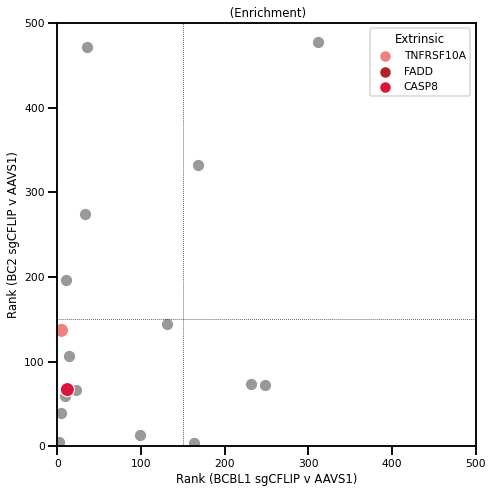

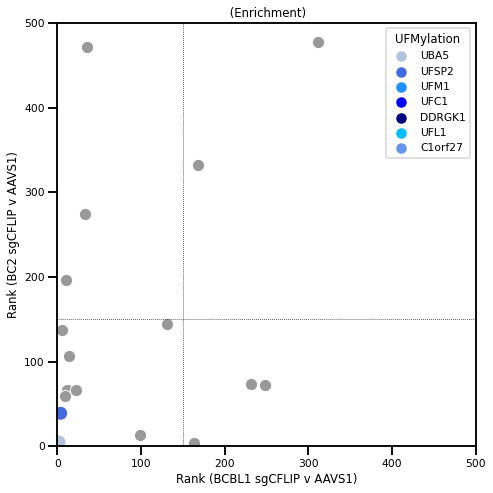

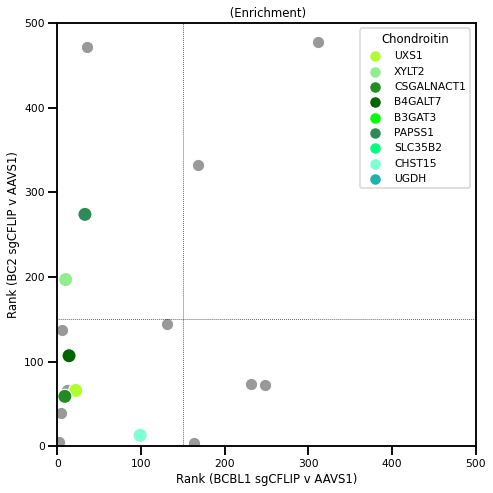

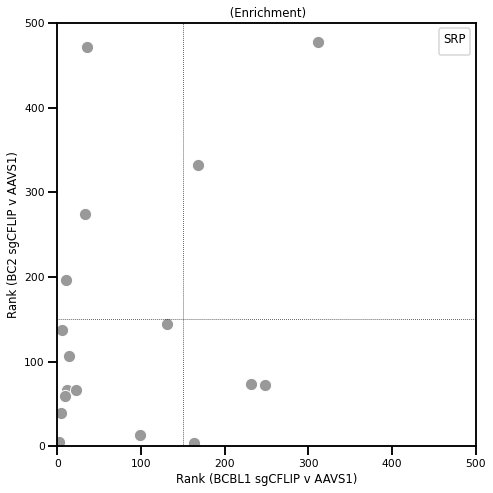

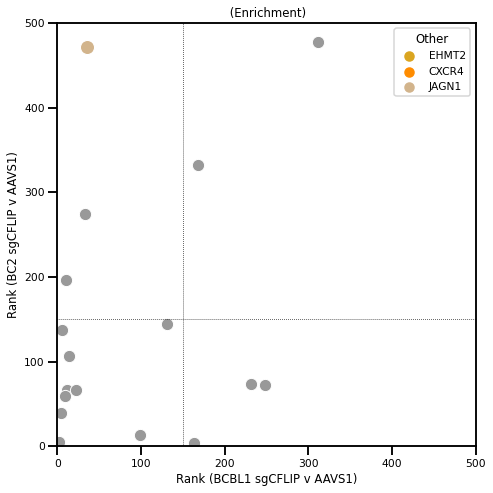

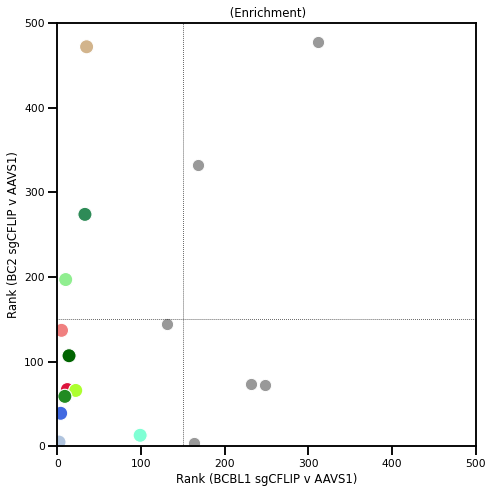

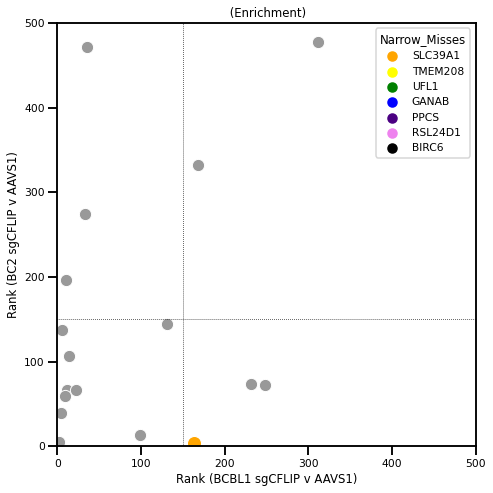

In [27]:
y_col = 'sgCFLIP_v_AAVS1_BC2_pos|rank'
x_col = 'sgCFLIP_v_AAVS1_BCBL1_pos|rank'
y_lim = 500
x_lim = 500
ranks_df = df[(df[y_col] <= y_lim) & (df[x_col] <= x_lim)].copy()
for geneset_name, geneset in genesets.items():
    draw_legend = geneset_name != 'High_Conf_Hits'
    label_and_plot_geneset(
        ranks_df,
        y_col = y_col,
        y_lab = 'Rank (BC2 sgCFLIP v AAVS1)',
        x_col = x_col,
        x_lab = 'Rank (BCBL1 sgCFLIP v AAVS1)',
        data_key = '',
        geneset = geneset,
        geneset_name = geneset_name,
        base_color = '.6',
        legend = draw_legend,
        x_line = 150,
        y_line = 150,
        x_lim = (0,x_lim),
        y_lim = (0,y_lim),
        figsize=(14,14),
        out_pref='Rank_sg',
        scale_factor=.5
        )

# Screen QC/metrics
Variability in screen quality is apparent (hence, why the rank values are used)

In [28]:
new_dfs = []
for data_key, df in data.items():
    mapper = {
        f'{data_key}_pos|fdr': 'pos|fdr',
        f'{data_key}_pos|p-value': 'pos|p-value',
        f'{data_key}_pos|lfc': 'pos|lfc',
        f'{data_key}_pos|rank': 'pos|rank'
    }
    df = df.rename(mapper, axis=1)
    df['Screen'] = data_key
    df.reset_index(inplace=True)
    new_dfs.append(df[['pos|fdr', 'pos|rank', 'pos|lfc', 'Screen', 'pos|p-value']])
new_df = pd.concat(new_dfs)
new_df['Screen'] = new_df['Screen'].astype('category')

In [29]:
TOP_GENES = 500
cat_order = [
    'sgCFLIP_v_AAVS1_BCBL1',
    'shCFLIP_v_Ren_BCBL1',
    'sgCFLIP_v_AAVS1_BC2']
new_df = new_df[new_df['pos|rank'] <= TOP_GENES]
new_df['Screen'] = new_df['Screen'].cat.reorder_categories(cat_order)
new_df.head()

,pos|fdr,pos|rank,pos|lfc,Screen,pos|p-value
291,0.764753,339,0.41125,shCFLIP_v_Ren_BCBL1,0.013850
396,0.515886,176,0.24771,shCFLIP_v_Ren_BCBL1,0.004780
1647,0.797351,385,0.27933,shCFLIP_v_Ren_BCBL1,0.016193
1722,0.664390,264,0.14010,shCFLIP_v_Ren_BCBL1,0.009251
1975,0.764753,338,1.27580,shCFLIP_v_Ren_BCBL1,0.013833


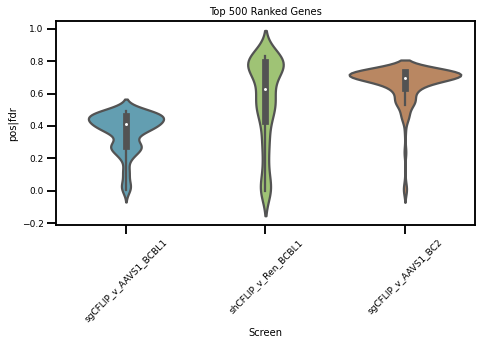

In [30]:
sns.set_context("talk", font_scale=.55)
plt.figure(figsize=(7.5,3.75))
sns.violinplot(data=new_df, x='Screen', y='pos|fdr', palette='turbo', saturation=.4)
plt.xticks(rotation=45)
plt.title(f'Top {TOP_GENES} Ranked Genes')
plt.savefig(f'top_{TOP_GENES}_violin_fdr.svg')

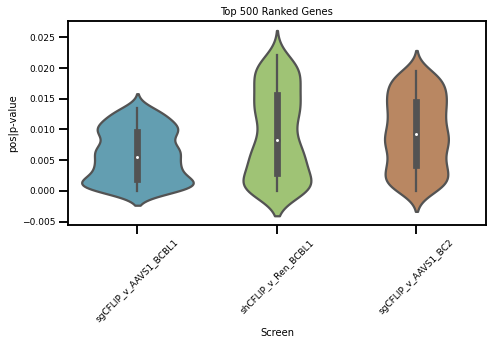

In [31]:
sns.set_context("talk", font_scale=.55)
plt.figure(figsize=(7.5,3.75))
sns.violinplot(data=new_df, x='Screen', y='pos|p-value', palette='turbo', saturation=.4)
plt.xticks(rotation=45)
plt.title(f'Top {TOP_GENES} Ranked Genes')
plt.savefig(f'top_{TOP_GENES}_violin_pval.svg')

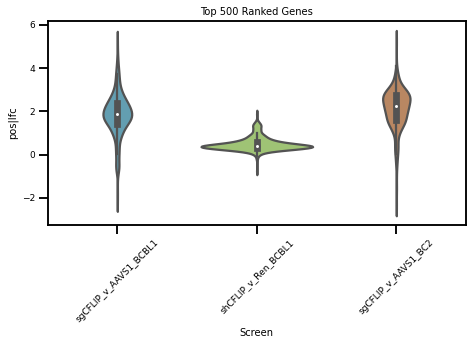

In [32]:
sns.set_context("talk", font_scale=.55)
plt.figure(figsize=(7.5,3.75))
sns.violinplot(data=new_df, x='Screen', y='pos|lfc', palette='turbo', saturation=.4)
plt.xticks(rotation=45)
plt.title(f'Top {TOP_GENES} Ranked Genes')
plt.savefig(f'top_{TOP_GENES}_violin_lfc.svg')
